Lucas Lima Neves - 201905463

#Análise Exploratória
Neste notebook será realizada uma análise exploratória do conjunto de dados públicos voltados para pólipos adenomatosos encontrados em exames de colonoscopia.

Os dados consistem em pares imagem-máscara de segmentação.

As máscaras correspondem às anotações dos pólipos encontrados na realização do exame.

O conjunto total será composto por três datasets: Kvasir-SEG, ETIS-LaribPolypDB e CVC-ClinicDB, cada um com seu respectivo padrão de nomenclatura e dimensões de imagem.

In [1]:
# Importação dos arquivos via Drive por praticidade

from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


##Coletar e agrupar os dados

In [22]:
import os
import random

kvasir_images = "/content/drive/Shareddrives/Projeto - ZSCAN/Datasets/Kvasir-SEG/images"
kvasir_masks = "/content/drive/Shareddrives/Projeto - ZSCAN/Datasets/Kvasir-SEG/masks"
cvc_images = "/content/drive/Shareddrives/Projeto - ZSCAN/Datasets/CVC-ClinicDB/PNG/Original"
cvc_masks = "/content/drive/Shareddrives/Projeto - ZSCAN/Datasets/CVC-ClinicDB/PNG/Ground Truth"
etislarib_images = "/content/drive/Shareddrives/Projeto - ZSCAN/Datasets/ETIS-LaribPolypDB/JPG_128x128"
etislarib_masks = "/content/drive/Shareddrives/Projeto - ZSCAN/Datasets/ETIS-LaribPolypDB/Ground Truth JPG_128x128"

images_path = [kvasir_images,cvc_images,etislarib_images]
masks_path = [kvasir_masks,cvc_masks,etislarib_masks]

image_files=[]
mask_files=[]
for path in images_path:
  all_files = os.listdir(path)
  for arquivo in all_files:
    arquivo = os.path.join(path,arquivo)
    image_files.append(arquivo)

for path in masks_path:
  all_files = os.listdir(path)
  for arquivo in all_files:
    arquivo = os.path.join(path,arquivo)
    mask_files.append(arquivo)

print("Diferentes diretórios para as imagens:")
print(image_files[0])
print(image_files[1001])
print(image_files[1802])
print("\n\n")
print(f"Quantidade total de imagens {len(image_files)}")
print(f"Quantidade total de Masks {len(image_files)}")



Diferentes diretórios para as imagens:
/content/drive/Shareddrives/Projeto - ZSCAN/Datasets/Kvasir-SEG/images/cjyzk8qieoboa0848ogj51wwm.jpg
/content/drive/Shareddrives/Projeto - ZSCAN/Datasets/CVC-ClinicDB/PNG/Original/225.png
/content/drive/Shareddrives/Projeto - ZSCAN/Datasets/ETIS-LaribPolypDB/JPG_128x128/140_ti.jpg



Quantidade total de imagens 1808
Quantidade total de Masks 1808


##Definição das funções que serão utilizadas

In [ ]:
import os
from collections import Counter
from PIL import Image, ImageDraw, ImageFont
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def create_image_montage1(image_path1, image_path2, image_path3): # Para três imagens
    try:
        img1 = Image.open(image_path1)
        img2 = Image.open(image_path2)
        img3 = Image.open(image_path3)

        width1, height1 = img1.size
        width2, height2 = img2.size
        width3, height3 = img3.size

        montage_width = width1 + width2 + width3
        montage_height = max(height1, height2, height3) + 50  # Adiciona espaço para o texto

        montage = Image.new("RGB", (montage_width, montage_height), "white")
        montage.paste(img1, (0, 50))
        montage.paste(img2, (width1, 50))
        montage.paste(img3, (width1 + width2, 50))

        draw = ImageDraw.Draw(montage)
        font = ImageFont.load_default()
        draw.fontmode = "L"
        draw.text((10, 10), os.path.basename(image_path1), fill="black", font=font)
        draw.text((width1 + 10, 10), os.path.basename(image_path2), fill="black", font=font)
        draw.text((width1 + width2 + 10, 10), os.path.basename(image_path3), fill="black", font=font)

        plt.figure(figsize=(15, 5))
        plt.imshow(montage)
        plt.axis("off")
        plt.show()
    except Exception as e:
        print(f"Erro ao criar montagem: {e}")

def convert_images_to_png(image_paths, output_folder):
    os.makedirs(output_folder, exist_ok=True)
    for path in image_paths:
        try:
            with Image.open(path) as img:
                filename = os.path.splitext(os.path.basename(path))[0] + ".png"
                img.save(os.path.join(output_folder, filename), "PNG")
        except Exception as e:
            print(f"Erro ao converter {path}: {e}")

def get_image_resolutions(image_paths):
    resolutions = []
    #count = 0
    for path in image_paths:
        try:
            with Image.open(path) as img:
                #count+=1
                #print(f"Arquivos processados {count}")
                width, height = img.size
                resolutions.append((width, height))
        except Exception as e:
            print(f"Erro ao processar {path}: {e}")

    return resolutions

def generate_resolution_table(resolutions):
    resolution_counts = Counter(resolutions)
    most_common_resolutions = resolution_counts.most_common(10)

    df = pd.DataFrame(most_common_resolutions, columns=["Resolução", "Frequência"])
    print(df)

    most_common = most_common_resolutions[0]
    least_common = min(resolution_counts.items(), key=lambda x: x[1])

    print(f"Resolução mais comum: {most_common[0]} pixels, aparecendo {most_common[1]} vezes")
    print(f"Resolução menos comum: {least_common[0]} pixels, aparecendo {least_common[1]} vezes")


def resize_images(image_paths, output_folder, target_size):
    os.makedirs(output_folder, exist_ok=True)
    for path in image_paths:
        try:
            with Image.open(path) as img:
                img = img.resize(target_size, Image.LANCZOS)
                filename = os.path.basename(path)
                img.save(os.path.join(output_folder, filename))
        except Exception as e:
            print(f"Erro ao redimensionar {path}: {e}")

def rename_images(image_folder):
    image_files = sorted([f for f in os.listdir(image_folder) if f.lower().endswith(('png', 'jpg', 'jpeg', 'tif', 'bmp'))])
    for i, filename in enumerate(image_files):
        old_path = os.path.join(image_folder, filename)
        new_filename = f"img_{i}.png"
        new_path = os.path.join(image_folder, new_filename)
        os.rename(old_path, new_path)
    print("Renomeação concluída.")

def create_image_montage(image_path1, image_path2): # Para uma imagem e uma mask apenas
    try:
        img1 = Image.open(image_path1)
        img2 = Image.open(image_path2)

        width1, height1 = img1.size
        width2, height2 = img2.size

        montage_width = width1 + width2
        montage_height = max(height1, height2) + 50  # Adiciona espaço para o texto

        montage = Image.new("RGB", (montage_width, montage_height), "white")
        montage.paste(img1, (0, 50))
        montage.paste(img2, (width1, 50))

        draw = ImageDraw.Draw(montage)
        font = ImageFont.load_default()
        draw.text((10, 10), os.path.basename(image_path1), fill="black", font=font)
        draw.text((width1 + 10, 10), os.path.basename(image_path2), fill="black", font=font)

        plt.figure(figsize=(10, 5))
        plt.imshow(montage)
        plt.axis("off")
        plt.show()
    except Exception as e:
        print(f"Erro ao criar montagem: {e}")

### Exibição das imagens originais

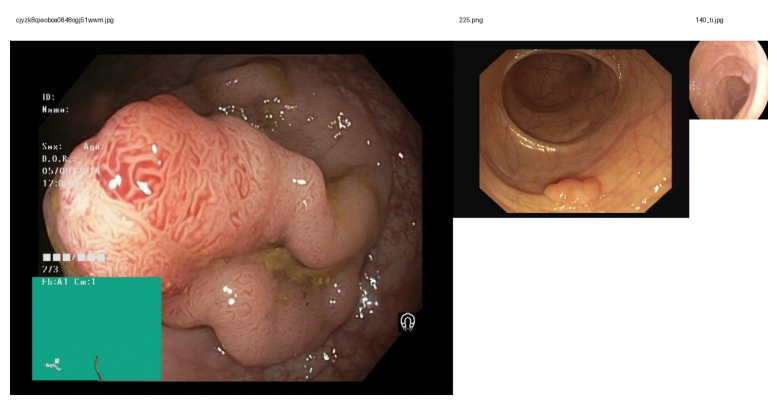

In [27]:
create_image_montage1(image_files[0], image_files[1001], image_files[1802])

As imagens estão exibidas de acordo com suas dimensões naturais e nomes naturais.

Como podemos ver, temos formatos diferentes (png e jpg). Resoluções altamente discrepantes e também sistemas de nomenclaturas diferentes.

As máscaras de segmentação acompanham os mesmos problemas das imagens, portanto também devem ser corrigidas da mesma forma.

##1º Passo - Correção do formato das imagens

###Identificar os formatos existentes atualmente no dataset

In [14]:
png_files = [file for file in image_files if file.lower().endswith('.png')]
tif_files = [file for file in image_files if file.lower().endswith('.tif')]
jpg_files = [file for file in image_files if file.lower().endswith('.jpeg') or file.lower().endswith('.jpg')]

print("Imagens em PNG:", len(png_files))
print("Imagens em TIFF:", len(tif_files))
print("Imagens em JPG:", len(jpg_files))

Imagens em PNG: 612
Imagens em TIFF: 0
Imagens em JPG: 1196


###Realizar a conversão de todos para PNG

In [42]:
# Iremos padronizar o formato png para manter a qualidade maior possível

convert_images_to_png(image_files, "/content/drive/MyDrive/LabIA/analise_exploratoria/images")
convert_images_to_png(mask_files, "/content/drive/MyDrive/LabIA/analise_exploratoria/images")

In [4]:
# Re-atribuindo o caminho correto para as imagens e masks
images_path = "/content/drive/MyDrive/LabIA/analise_exploratoria/images"
masks_path = "/content/drive/MyDrive/LabIA/analise_exploratoria/masks"

image_files=[]
mask_files=[]

all_files = os.listdir(images_path)
for arquivo in all_files:
  arquivo = os.path.join(images_path,arquivo)
  image_files.append(arquivo)


all_files = os.listdir(masks_path)
for arquivo in all_files:
  arquivo = os.path.join(masks_path,arquivo)
  mask_files.append(arquivo)

In [5]:
# Recontando
png_files = [file for file in image_files if file.lower().endswith('.png')]
tif_files = [file for file in image_files if file.lower().endswith('.tif')]
jpg_files = [file for file in image_files if file.lower().endswith('.jpeg') or file.lower().endswith('.jpg')]

print("Imagens em PNG:", len(png_files))
print("Imagens em TIFF:", len(tif_files))
print("Imagens em JPG:", len(jpg_files))

Imagens em PNG: 1808
Imagens em TIFF: 0
Imagens em JPG: 0


##2º Passo - Correção da dimensionalidade das imagens

###Para corrigir a dimensão das imagens, primeiro vamos encontrar qual é a resolução mais comum no conjnto de dados.

In [41]:
resolutions = get_image_resolutions(image_files)
generate_resolution_table(resolutions)


  Total de Pixels  Frequência
0      (384, 288)         612
1      (128, 128)         196
2      (622, 530)          78
3      (626, 547)          66
4      (626, 546)          61
5      (622, 529)          56
6      (622, 528)          53
7      (622, 531)          50
8      (570, 530)          33
9      (570, 531)          19
Resolução mais comum: (384, 288) pixels, aparecendo 612 vezes
Resolução menos comum: (585, 530) pixels, aparecendo 1 vezes


### Como a resolução mais comum é 384x288, os arquivos serão adaptados todos para operarem nesta resolução.

In [7]:
# Vamos padronizar de acordo com a resolução mais comum
resize_images(image_files, "/content/drive/MyDrive/LabIA/analise_exploratoria/images_resized",(384, 288))
resize_images(mask_files, "/content/drive/MyDrive/LabIA/analise_exploratoria/masks_resized",(384, 288))


# Re-atribuindo o caminho correto para as imagens e masks
images_path = "/content/drive/MyDrive/LabIA/analise_exploratoria/images_resized"
masks_path = "/content/drive/MyDrive/LabIA/analise_exploratoria/masks_resized"

image_files=[]
mask_files=[]

all_files = os.listdir(images_path)
for arquivo in all_files:
  arquivo = os.path.join(images_path,arquivo)
  image_files.append(arquivo)


all_files = os.listdir(masks_path)
for arquivo in all_files:
  arquivo = os.path.join(masks_path,arquivo)
  mask_files.append(arquivo)

In [10]:
resolutions = get_image_resolutions(image_files)
generate_resolution_table(resolutions)

  Total de Pixels  Frequência
0      (384, 288)        1808
Resolução mais comum: (384, 288) pixels, aparecendo 1808 vezes
Resolução menos comum: (384, 288) pixels, aparecendo 1808 vezes


##3º Passo - Correção dos padrões de nomenclatura



###Há três padrões diferentes de nomenclatura:
Kvasir: "c"+ {random_string} + ".jpg"

CVC : {id} + ".png"

EtisLarib: {id} + ".jpg"

###A nomenclatura deve ser padronizada, evitando repetições entre as que já existem dentre os datasets e mantendo a relação entre o mesmo nome entre imagem e sua respectiva máscara.

In [13]:
# Renomear imagens padronizando os nomes
rename_images("/content/drive/MyDrive/LabIA/analise_exploratoria/images_resized")
rename_images("/content/drive/MyDrive/LabIA/analise_exploratoria/masks_resized")

Renomeação concluída.
Renomeação concluída.


In [14]:
# Re-atribuindo o caminho correto para as imagens e masks
images_path = "/content/drive/MyDrive/LabIA/analise_exploratoria/images_resized"
masks_path = "/content/drive/MyDrive/LabIA/analise_exploratoria/masks_resized"

image_files=[]
mask_files=[]

all_files = os.listdir(images_path)
for arquivo in all_files:
  arquivo = os.path.join(images_path,arquivo)
  image_files.append(arquivo)


all_files = os.listdir(masks_path)
for arquivo in all_files:
  arquivo = os.path.join(masks_path,arquivo)
  mask_files.append(arquivo)



###Exibição de alguns dos caminhos para verificar se a troca de nomes ocorreu bem

In [15]:
for i in range(10):
  print(image_files[i])

/content/drive/MyDrive/LabIA/analise_exploratoria/images_resized/img_1429.png
/content/drive/MyDrive/LabIA/analise_exploratoria/images_resized/img_1466.png
/content/drive/MyDrive/LabIA/analise_exploratoria/images_resized/img_1438.png
/content/drive/MyDrive/LabIA/analise_exploratoria/images_resized/img_1463.png
/content/drive/MyDrive/LabIA/analise_exploratoria/images_resized/img_1452.png
/content/drive/MyDrive/LabIA/analise_exploratoria/images_resized/img_1423.png
/content/drive/MyDrive/LabIA/analise_exploratoria/images_resized/img_1446.png
/content/drive/MyDrive/LabIA/analise_exploratoria/images_resized/img_1419.png
/content/drive/MyDrive/LabIA/analise_exploratoria/images_resized/img_1464.png
/content/drive/MyDrive/LabIA/analise_exploratoria/images_resized/img_1414.png


##Imagens e suas respectivas máscaras de segmentação após o processo de correção do dataset

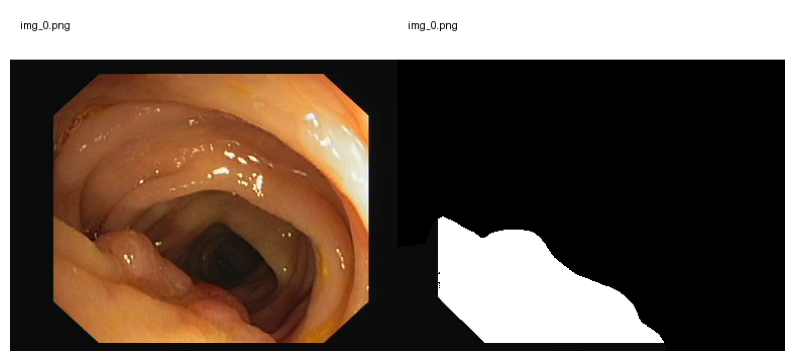

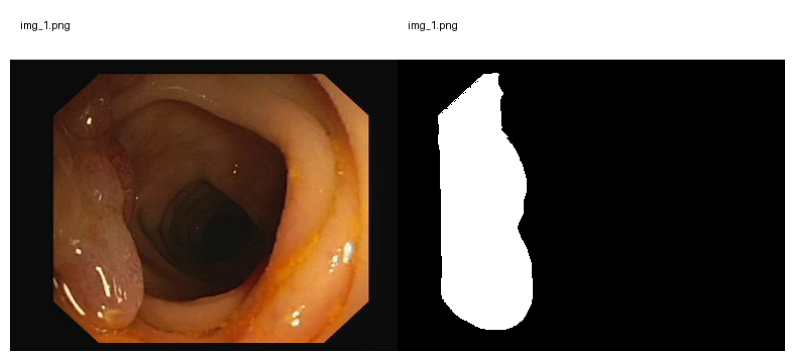

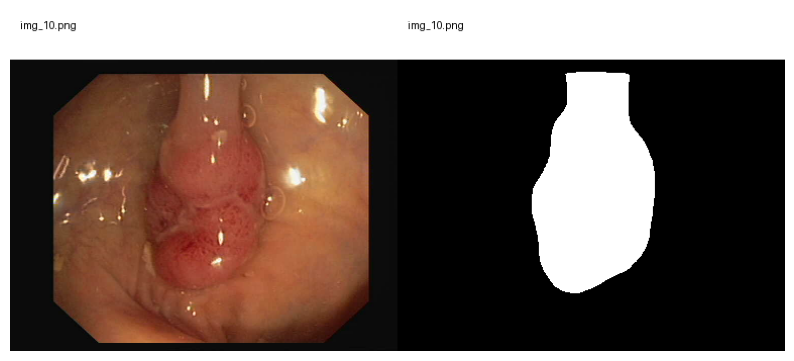

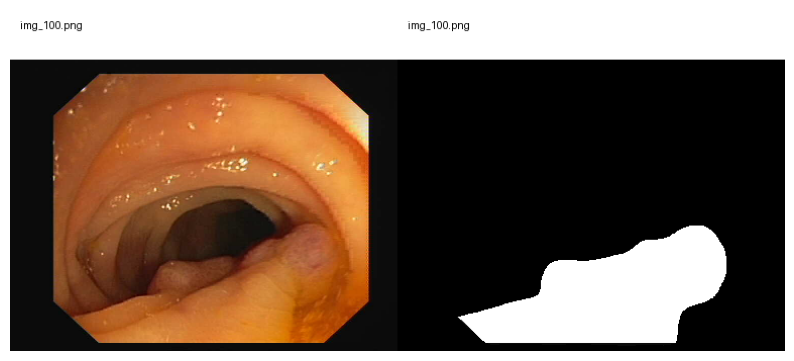

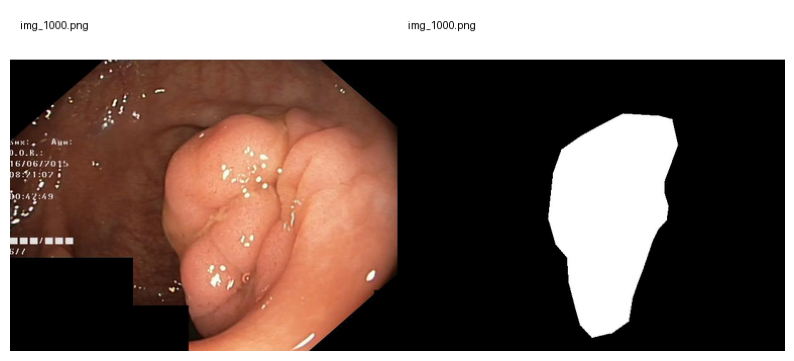

In [19]:
images = np.sort(image_files)
masks = np.sort(mask_files)

for i in range(5):
  create_image_montage(images[i],masks[i])

##Ao final do processo possuimos 1808 imagens, todas no mesmo formato (.png), seguindo o mesmo procedimento de nomenclatura (img_id.png) e com a mesma resolução (384,288).